In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_pickle('data/processed_mutations.dataset')
df

,#Feature AC,Feature range(s),Original sequence,Resulting sequence,Feature short label,Feature type,Feature annotation,Affected protein AC,Affected protein symbol,Affected protein full name,...,mut0,parAC,par0,mut1,label,mutAC1,mut0_51,mut1_51,mut0_1025,mut1_1025
5,EBI-10039489,[81-81],[V],[E],P28795:p.Val81Glu,mutation disrupting(MI:0573),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,0,P28795_P28795:p.Val81Glu,IKEQIKRRFEQTQEDSLYTIYELLPVWRMVLNENDLNLDSIVTQLK...,IKEQIKRRFEQTQEDSLYTIYELLPEWRMVLNENDLNLDSIVTQLK...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
6,EBI-10039495,[188-188],[N],[I],P28795:p.Asn188Ile,mutation decreasing(MI:0119),,P28795,PEX3,,...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,Q03694,MVLSRGETKKNSVRLTAKQEKKPQSTFQTLKQSLKLSNNKKLKQDS...,MAPNQRSRSLLQRHRGKVLISLTGIAALFTTGSVVVFFVKRWLYKQ...,1,P28795_P28795:p.Asn188Ile,NEYLDSAIKLTMQQENCNKLQNRFYNWVTSWWSDPEDKADDAMVMA...,NEYLDSAIKLTMQQENCNKLQNRFYIWVTSWWSDPEDKADDAMVMA...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
10,EBI-10039873,[146-146],[K],[R],O95863:p.Lys146Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_O95863:p.Lys146Arg,LEAEAYAAFPGLGQVPKQLAQLSEAKDLQARKAFNCKYCNKEYLSL...,LEAEAYAAFPGLGQVPKQLAQLSEARDLQARKAFNCKYCNKEYLSL...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
11,EBI-10039883,[187-187],[K],[R],O95863:p.Lys187Arg,mutation decreasing strength(MI:1133),,O95863,SNAI1,,...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,Q09472,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,MPRSFLVRKPSDPNRKPNYSELQDSNPEFTFQQPYDQAHLLAAIPP...,1,O95863_O95863:p.Lys187Arg,EYLSLGALKMHIRSHTLPCVCGTCGKAFSRPWLLQGHVRTHTGEKP...,EYLSLGALKMHIRSHTLPCVCGTCGRAFSRPWLLQGHVRTHTGEKP...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
15,EBI-10041181,[368-368],[W],[A],Q9UKV5:p.Trp368Ala,mutation decreasing(MI:0119),,Q9UKV5,AMFR,,...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,P60604,MAGTALKRLMAEYKQLTLNPPEGIVAGPMNEENFFEWEALIMGPED...,MPLLFLERFPWPSLRTYTGLSGLALLGTIISAYRALSQPEAGPGEP...,1,Q9UKV5_Q9UKV5:p.Trp368Ala,ICWDSMQAARKLPCGHLFHNSCLRSWLEQDTSCPTCRMSLNIADNN...,ICWDSMQAARKLPCGHLFHNSCLRSALEQDTSCPTCRMSLNIADNN...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44403,EBI-9993467,[413-413],[S],[A],P41279:p.Ser413Ala,mutation decreasing(MI:0119),,P41279,MAP3K8,,...,MEYMSTGSDNKEEIDLLIKHLNVSDVIDIMENLYASEEPAVYEPSL...,Q13526,MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGK...,MEYMSTGSDNKEEIDLLIKHLNVSDVIDIMENLYASEEPAVYEPSL...,1,P41279_P41279:p.Ser413Ala,LNPPREDQPRCQSLDSALLERKRLLSRKELELPENIADSSCTGSTE...,LNPPREDQPRCQSLDSALLERKRLLARKELELPENIADSSCTGSTE...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
44406,EBI-9994728,[418-418],[D],[A],Q53EL6:p.Asp418Ala,mutation decreasing(MI:0119),,Q53EL6,PDCD4,,...,MDVENEQILNVNPADPDNLSDSLFSGDEENAGTEEIKNEINGNWIS...,P60842,MSASQDSRSRDNGPDGMEPEGVIESNWNEIVDSFDDMNLSESLLRG...,MDVENEQILNVNPADPDNLSDSLFSGDEENAGTEEIKNEINGNWIS...,1,Q53EL6_Q53EL6:p.Asp418Ala,SSTITVDQMKRGYERIYNEIPDINLDVPHSYSVLERFVEECFQAGI...,SSTITVDQMKRGYERIYNEIPDINLAVPHSYSVLERFVEECFQAGI...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
44409,EBI-9998311,[300-300],[T],[A],Q676U5:p.Thr300Ala,mutation increasing rate(MI:1131),,Q676U5,ATG16L1,,...,MSSGLRAADFPRWKRHISEQLRRRDRLQRQAFEEIILQYNKLLEKS...,P42574,MENTENSVDSKSIKNLEPKIIHGSESMDSGISLDNSYKMDYPEMGL...,MSSGLRAADFPRWKR

In [4]:

df['mut0_length'] = df['mut0'].apply(len)
avg_len = df['mut0_length'].mean()
print(f"mut0 averge length: {avg_len:.2f}")

label_counts = df['label'].value_counts().sort_index()
label_percent = (label_counts / len(df)) * 100

label_stats = pd.DataFrame({
    'count': label_counts,
    'percent(%)': label_percent.round(2)
})

print("\nlabel count")
print(label_stats)


mut0 averge length: 804.52

label count
       count  percent(%)
label                   
0       8547       36.03
1       5260       22.17
2       8087       34.09
3       1435        6.05
4        395        1.66


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

df = pd.read_pickle("data/processed_mutations.dataset")

df["mut_pos"] = (
    df["Feature range(s)"]
      .astype(str)
      .str.extract(r"(\d+)")
      .astype(int)
)


train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)
df.loc[train_idx, "split"] = "train"
df.loc[test_idx,  "split"] = "test"


def local_consistency_pair(table, windows, *,
                           id_col="Affected protein AC",
                           pos_col="mut_pos",
                           label_col="label"):
    df_tr = table[table["split"]=="train"]
    df_te = table[table["split"]=="test"]

    prot2train = defaultdict(list)
    for _, r in df_tr.iterrows():
        prot2train[r[id_col]].append((r[pos_col], r[label_col]))

    result = []
    for w in windows:
        cons = inc = 0
        for _, t in df_te.iterrows():
            neigh = [(p, lab) for p, lab in prot2train.get(t[id_col], [])
                     if abs(p - t[pos_col]) <= w]
            # print(t[label_col], neigh)
            for _, lab in neigh:
                if lab == t[label_col]:
                    cons += 1
                else:
                    inc += 1
        tot = cons + inc
        result.append({"window size": w,
                       "pairs": tot,
                       "consistent": cons,
                       "ratio": cons / tot if tot else None})
    return pd.DataFrame(result)

windows = [1,10,50,100]        # 1–100
res = local_consistency_pair(df, windows)
print(res)


   window size   pairs  consistent     ratio
0            1  382648      171865  0.449146
1           10  414291      189439  0.457261
2           50  440118      205637  0.467232
3          100  451743      211756  0.468753


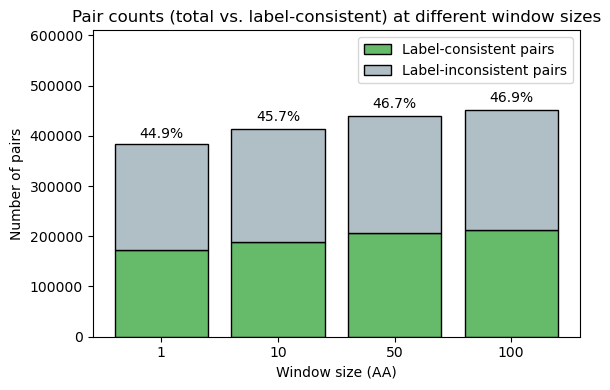

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cons = pd.DataFrame({
    "window": [1, 10, 50, 100],
    "pairs":  [382648, 414291, 440118, 451743],
    "consistent": [171865, 189439, 205637, 211756]
})
cons["inconsistent"] = cons["pairs"] - cons["consistent"]
cons["ratio"] = cons["consistent"] / cons["pairs"]

cons["window_cat"] = cons["window"].astype(str)  

plt.figure(figsize=(6, 4))

x = range(len(cons))

plt.bar(
    x,
    cons["consistent"],
    color="#66BB6A",
    edgecolor="black",
    label="Label-consistent pairs"
)

plt.bar(
    x,
    cons["inconsistent"],
    bottom=cons["consistent"],
    color="#B0BEC5",
    edgecolor="black",
    label="Label-inconsistent pairs"
)

for xi, total, ratio in zip(x, cons["pairs"], cons["ratio"]):
    plt.text(
        xi,
        total + total * 0.02,
        f"{ratio:.1%}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xticks(x, cons["window_cat"])
plt.xlabel("Window size (AA)")
plt.ylabel("Number of pairs")
plt.title("Pair counts (total vs. label-consistent) at different window sizes")

plt.ylim(0, cons["pairs"].max() * 1.35) 

plt.tight_layout()

plt.legend()

plt.savefig("consistency_by_window.png",
            dpi=300, bbox_inches="tight", transparent=False)
plt.show()


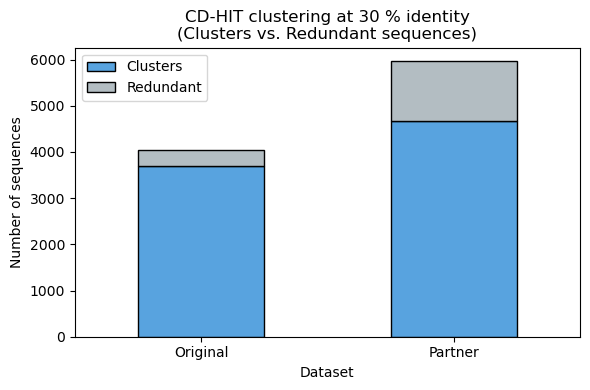

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "Dataset":    ["Original", "Partner"],
    "Sequences":  [4042, 5959],
    "Clusters":   [3699, 4675]
}
df_hom = pd.DataFrame(data)
df_hom["Redundant"] = df_hom["Sequences"] - df_hom["Clusters"]

plt.figure(figsize=(6, 4))

bar_width = 0.5

sns.barplot(
    data=df_hom, x="Dataset", y="Clusters",
    color="#42A5F5", edgecolor="black",
    label="Clusters", width=bar_width
)

sns.barplot(
    data=df_hom, x="Dataset", y="Redundant",
    bottom=df_hom["Clusters"],
    color="#B0BEC5", edgecolor="black",
    label="Redundant", width=bar_width
)


plt.ylabel("Number of sequences")
plt.title("CD-HIT clustering at 30 % identity\n(Clusters vs. Redundant sequences)")
plt.legend()
plt.tight_layout()
plt.savefig("cdhit_clustering.png", dpi=300, bbox_inches="tight", transparent=False)
plt.show()
